# DG H-S Paper: FMS comparison

In [3]:
#modules
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import ndimage
from scipy import integrate

In [4]:
xi = 20. # scaling faocr (some daigs need to be adapted as used Earth radius)

In [10]:
# data extraction helpers
def print_ncinfo(dataset):
    for var in dataset.variables:
        var1 = dataset.variables[var]
        for name in var1.ncattrs():
            print var, '-->',name, '=', getattr(var1,name)
            
def append_year_days_onevar(fn, day_list, var_name, enable_print_ncinfo=False):
    ncdata =Dataset(fn%1,'r')
    if enable_print_ncinfo==True:
        print_ncinfo(ncdata)
    zon_waven = ncdata.variables['zon_waven'][:]
    legendre = ncdata.variables['legendre'][:]
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    var_=ncdata.variables[var_name][:]
    ncdata.close()
    var = np.zeros((np.shape(var_)))[np.newaxis, ...]
    for d_i, d in enumerate(day_list):
        ncdata = Dataset(fn%d,'r')
        var=np.append(var, (ncdata.variables[var_name][:])[np.newaxis, ...], axis = 0)
        ncdata.close()
    
    return zon_waven, legendre, lat, lon, sig, var


def append_year_days_zonal_mean(fn, day_list, eddy_stats = True, enable_print_ncinfo=False):
    ncdata =Dataset(fn%1,'r')
    if enable_print_ncinfo==True:
        print_ncinfo(ncdata)
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    ncdata.close()
    v = np.zeros((len(day_list), len(sig), len(lat)))
    u = np.zeros((len(day_list), len(sig), len(lat)))
    T = np.zeros((len(day_list), len(sig), len(lat)))
    uv = np.zeros((len(day_list), len(sig), len(lat)))
    vT = np.zeros((len(day_list), len(sig), len(lat)))
    TT = np.zeros((len(day_list), len(sig), len(lat)))
    eke = np.zeros((len(day_list), len(sig), len(lat)))
    for d_i, d in enumerate(day_list):
        ncdata = Dataset(fn%d,'r')
        v[d_i,:,:]=np.mean(ncdata.variables['v'][:],axis=-1) / xi
        u[d_i,:,:]=np.mean(ncdata.variables['u'][:],axis=-1) / xi
        T[d_i,:,:]=np.mean(ncdata.variables['temp'][:],axis=-1)
        if eddy_stats ==True:
            vST = ncdata.variables['v'][:]/ xi - v[d_i,:,:,None]
            uST = ncdata.variables['u'][:]/ xi - u[d_i,:,:,None]           
            TST = ncdata.variables['temp'][:] - T[d_i,:,:,None]
            uv[d_i,:,:]=np.mean(uST*vST,axis=-1)
            vT[d_i,:,:]=np.mean(vST*TST,axis=-1)
            TT[d_i,:,:]=np.mean(TST*TST,axis=-1)
            eke[d_i,:,:]=np.mean(uST**2+vST**2,axis=-1)
        ncdata.close()
    
    return lat, lon, sig, v, u, T, uv, vT, TT, eke

# Zonal means

In [11]:
# dirs / fnames
day_list = np.arange(400,644)
exp_name = "hs_small_planet_num_fourier_63_num_num_spherical_64_lon_max_192_lat_max_96_num_levels_30_include_surface_flux_.false._turb_.false._damping_coeff_0.0_dt_atmos_20_xi_sp_20.0"
data_dir = "/central/scratch/elencz/caltech_fms_idealized/hs_small_planet/%s/output/ppp_output_BUP/"%exp_name
fname = "day1000h00.segment%s.nc"



In [5]:
lat, lon, sig, v, u, T, uv, vT, TT, eke = append_year_days_zonal_mean(data_dir+fname, day_list)

In [6]:
# plotting helpers
def zonal_plot(lat, lev, var, title = '', subplot_no=(1,1,1), vrange = 20):
    a,b,c = subplot_no
    plt.subplot(a,b,c)
    f1 = plt.contourf(lat, lev, var, vrange)
    plt.colorbar(f1)
    plt.gca().invert_yaxis()
    plt.title(title)

# diagnostic helpers
def psi(V_xBAR,level_list_array,lat):
    _a, _g = (6371000. , 9.81) # Earth_radius, grav_constant
    latrad = lat*np.pi/180.
    psi = _a/_g * 2. * np.pi * np.cos(latrad)[None,None,:] * integrate.cumtrapz(V_xBAR,level_list_array,axis = 1)
    return psi



hs_small_planet_num_fourier_63_num_num_spherical_64_lon_max_192_lat_max_96_num_levels_30_include_surface_flux_.false._turb_.false._damping_coeff_0.0_dt_atmos_20_xi_sp_20.0


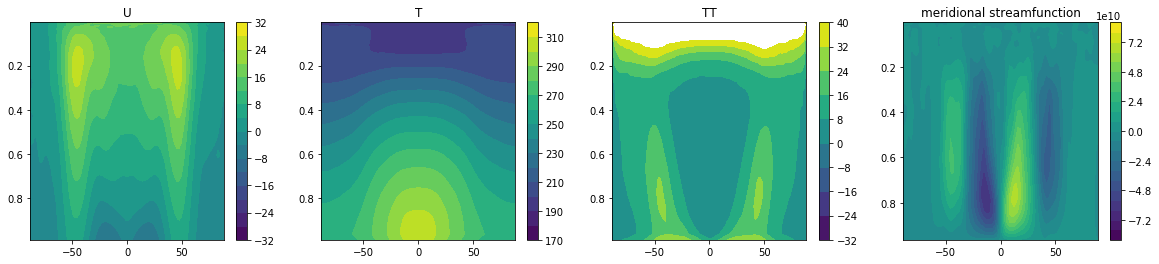

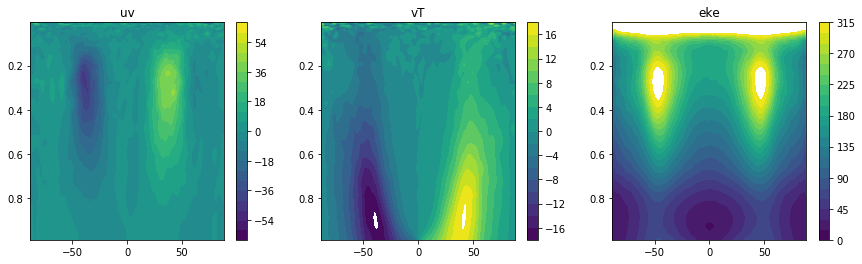

In [7]:
# Viz zonal means

# U, T, meridional streamfunctions
plt.figure(figsize=(20,4))
zonal_plot(lat, sig, np.mean(u,axis=0), title = 'U', subplot_no = (1,4,1), vrange = np.arange(-32,33,4))
zonal_plot(lat, sig, np.mean(T,axis=0), title = 'T', subplot_no = (1,4,2), vrange = np.arange(170,330,10))
zonal_plot(lat, sig, np.mean(TT,axis=0), title = 'TT', subplot_no = (1,4,3), vrange = np.arange(-32,41,8))
pressure = sig * 100000.0 # units: Pa
zonal_plot(lat, sig[:-1], np.mean(psi(v, pressure ,lat),axis=0), title = 'meridional streamfunction', subplot_no = (1,4,4), vrange = np.arange(-8.8e10,8.9e10,0.8e10))

# vT, uv, u^2+v^2, TT
plt.figure(figsize=(20,4))
zonal_plot(lat, sig, np.mean(uv,axis=0), title = 'uv', subplot_no = (1,4,1) , vrange = np.arange(-66,67,6))
zonal_plot(lat, sig, np.mean(vT,axis=0), title = 'vT', subplot_no = (1,4,2) , vrange = np.arange(-18,19,2))
zonal_plot(lat, sig, np.mean(0.5*eke,axis=0), title = 'eke', subplot_no = (1,4,3), vrange = np.arange(0,330,15))


print(exp_name)

# Spectral

In [12]:
# spectral info
zonal_wn, legendre, lat, lon, sig, var = append_year_days_onevar(data_dir+fname, day_list, 'pot_temp_psd') #flipped (zon_wavenDimID, legendreDimID, sigmaDimID)




(245, 30, 64, 64)


/central/home/elencz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


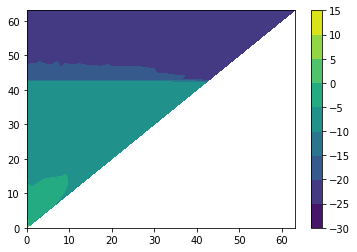

In [13]:
print(np.shape(var))

sig_i700 = [i for i,x in enumerate(sig) if ((x > 0.7) & (x < 0.8))][0]
f1 = plt.contourf(legendre, zonal_wn, np.log(np.mean(var,axis=0)[sig_i700,:,:]/20.))#, np.arange(-10e-2, 10e-2, 10e-3))
plt.colorbar(f1)



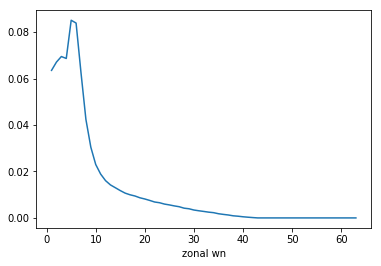

In [14]:
plt.plot(zonal_wn[1:],np.mean(var[1:,sig_i700,:,1:],axis=(0,-2)))
plt.xlabel("power spectral density")
plt.xlabel("zonal wn")
plt.show()

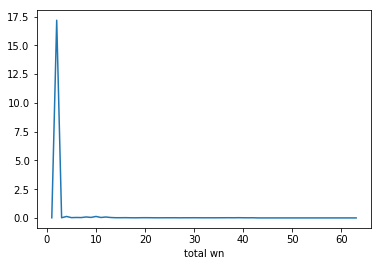

In [15]:
#plt.plot(zonal_wn[1:],np.mean(var[1:,sig_i700,:,1:],axis=(0,-2)))
plt.plot(zonal_wn[1:],np.mean(var[101,sig_i700,1:,:],axis=(-1)))
plt.xlabel("power spectral density")
plt.xlabel("total wn")
plt.show()

# Horizontal animation

In [ ]:
# Viz animation

zonal_wn, legendre, lat, lon, sig, u_full = append_year_days_onevar(data_dir+fname, day_list, 'u')

In [ ]:
plt.contourf(lon, lat, (u_full[1,sig_i500,:,:]))
from IPython.display import HTML

In [ ]:
#%matplotlib notebook
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

sig_i700 = [i for i,x in enumerate(sig) if ((x > 0.7) & (x < 0.8))][0]


plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
f1 = ax.contourf(lon, lat, u[1,sig_i700,:,:],np.arange(-30,30,1))
plt.colorbar(f1)

def animate(frame_num):
    ax.clear()
    ax.contourf(lon, lat, u[frame_num,sig_i700,:,:],np.arange(-30,30,1))
    ax.set_title('%03d'%frame_num) 
    return ax
    
anim = animation.FuncAnimation(fig, animate, 300, interval=50, blit=False)
plt.show()

# Snapshot of w

In [65]:
fn = data_dir+fname
d = 444
ncdata = Dataset(fn%d,'r')
# v_snap=ncdata.variables['v'][:] / xi
u_snap=ncdata.variables['u'][:] / xi
# T_snap=ncdata.variables['temp'][:]
w_snap=ncdata.variables['w'][:] / xi
lat = ncdata.variables['lat'][:]
lon = ncdata.variables['lon'][:]
sig=ncdata.variables['sigma'][:]



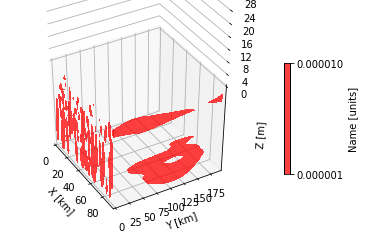

In [66]:
import matplotlib.colors as mcolors

colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

# Define dimensions
sig = np.arange(0,len(sig))

X, Y, Z = np.meshgrid(np.arange(0,len(lat)), np.arange(0,len(lon)), -sig)

# Create fake data
data = np.transpose(w_snap)*1.0

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': [1e-6, 10e-6],#np.linspace(data.min(), data.max(), 10),
    'cmap': cmapred,
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
# edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [km]',
    ylabel='Y [km]',
    zlabel='Z [m]',
    zticks=sig[::4],
)

# Set distance and angle view
ax.view_init(40, -30)
ax.dist = 11

# Colorbar
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

(array([1.20000e+01, 2.50000e+02, 4.16300e+03, 3.12710e+04, 3.04508e+05,
        1.85689e+05, 2.40390e+04, 2.79200e+03, 2.19000e+02, 1.70000e+01]),
 array([-2.33941769e-05, -1.86392149e-05, -1.38842528e-05, -9.12929071e-06,
        -4.37432864e-06,  3.80633435e-07,  5.13559551e-06,  9.89055758e-06,
         1.46455197e-05,  1.94004817e-05,  2.41554438e-05]),
 <a list of 10 Patch objects>)

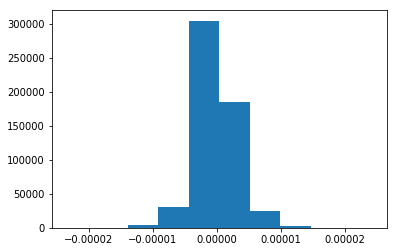

In [67]:
plt.hist(np.ndarray.flatten(w_snap))

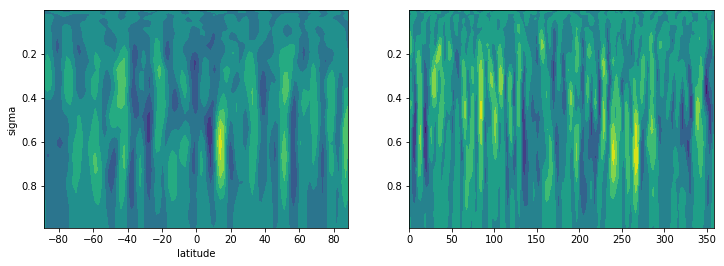

In [68]:
sig=ncdata.variables['sigma'][:]
data = np.transpose(w_snap)*1.0
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(lat, sig, np.transpose(data[int(len(lon)/2),:,:]))
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.contourf(lon, sig, np.transpose(data[:,int(len(lat)/2),:]))
plt.gca().invert_yaxis()


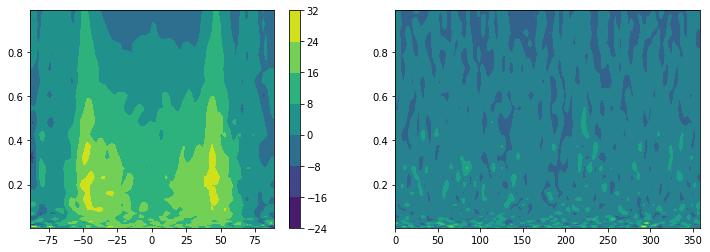

In [69]:
plt.figure(figsize=(12,4))
data = np.transpose(u_snap)*1.0
plt.subplot(1,2,1)
c = plt.contourf(lat, sig, np.transpose(np.mean(data[:,:,:],axis=0)))
plt.colorbar(c)

plt.subplot(1,2,2)
plt.contourf(lon, sig, np.transpose(data[:,int(len(lat)/2),:]))



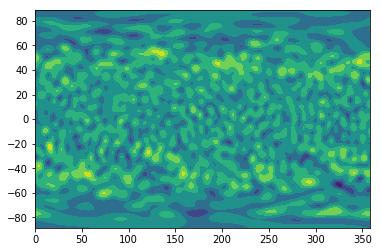

In [70]:
sig_i500 = [i for i,x in enumerate(sig) if ((x > 0.5) & (x < 0.6))][0]
plt.contourf(lon, lat, (u_snap[sig_i500,:,:]))

In [72]:
sig[sig_i500]

0.543744683265686

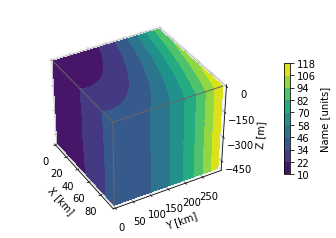

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D 

# Define dimensions
Nx, Ny, Nz = 100, 300, 500
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

# Create fake data
data = (((X+100)**2 + (Y-20)**2 + 2*Z)/1000+1)

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [km]',
    ylabel='Y [km]',
    zlabel='Z [m]',
    zticks=[0, -150, -300, -450],
)

# Set distance and angle view
ax.view_init(40, -30)
ax.dist = 11

# Colorbar
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

